# Validate a tool against IDR data

A set of walkthroughs showing the [exploration of IDR via the User Interface](Exploring_IDR_UI.ipynb) is available in both text and video versions. These walkthroughs show the publication mentioned below and images from it in a larger context inside IDR and how it is linked to external resources.

IDR is based on [OMERO](https://www.openmicroscopy.org/omero/) and thus all what we show in this notebook can be easily adjusted for use against another OMERO server, e.g. your institutional OMERO server instance.

The main objective of this notebook is to demonstrate how public resources such as the IDR can be used to train your neural network or validate software tools.

The authors of the PLOS Biology paper, "Nessys: A new set of tools for the automated detection of nuclei within intact tissues and dense 3D cultures" published in August 2019: https://doi.org/10.1371/journal.pbio.3000388, considered several image segmenation packages, but they did not use the approach described in this notebook. We will analyse the data using [StarDist](https://github.com/stardist/stardist) software package and compare the output with the original segmentation produced by the authors. StarDist was not considered by the authors. Our workflow shows how public repository can be accessed and data inside it used to validate software tools or new algorithms.

We will use an image (``id=6001247``) referenced in the paper. The image can be viewed online in the [Image Data Resource](https://idr.openmicroscopy.org/webclient/?show=image-6001247) (IDR).

We will use a predefined model from StarDist as a starting point. Steps to access data from IDR could be re-used if you wish to create a new model (outside the scope of this notebook).

The objectives of this notebook:

* How to access public resource via the [Python API](https://omero-guides.readthedocs.io/en/latest/python/docs/index.html).
* How to load image data.
* How to load binary data.
* How to load Regions of Interest (ROIs) associated to an image.
* Compare ROIs submitted by the authors and the ones generated using StarDist to validate the model used.

Loading data via the API **does not** write a file on disk. If you wish to download file(s) from IDR and write them on disk, please check [Data download](https://idr.openmicroscopy.org/about/download.html).

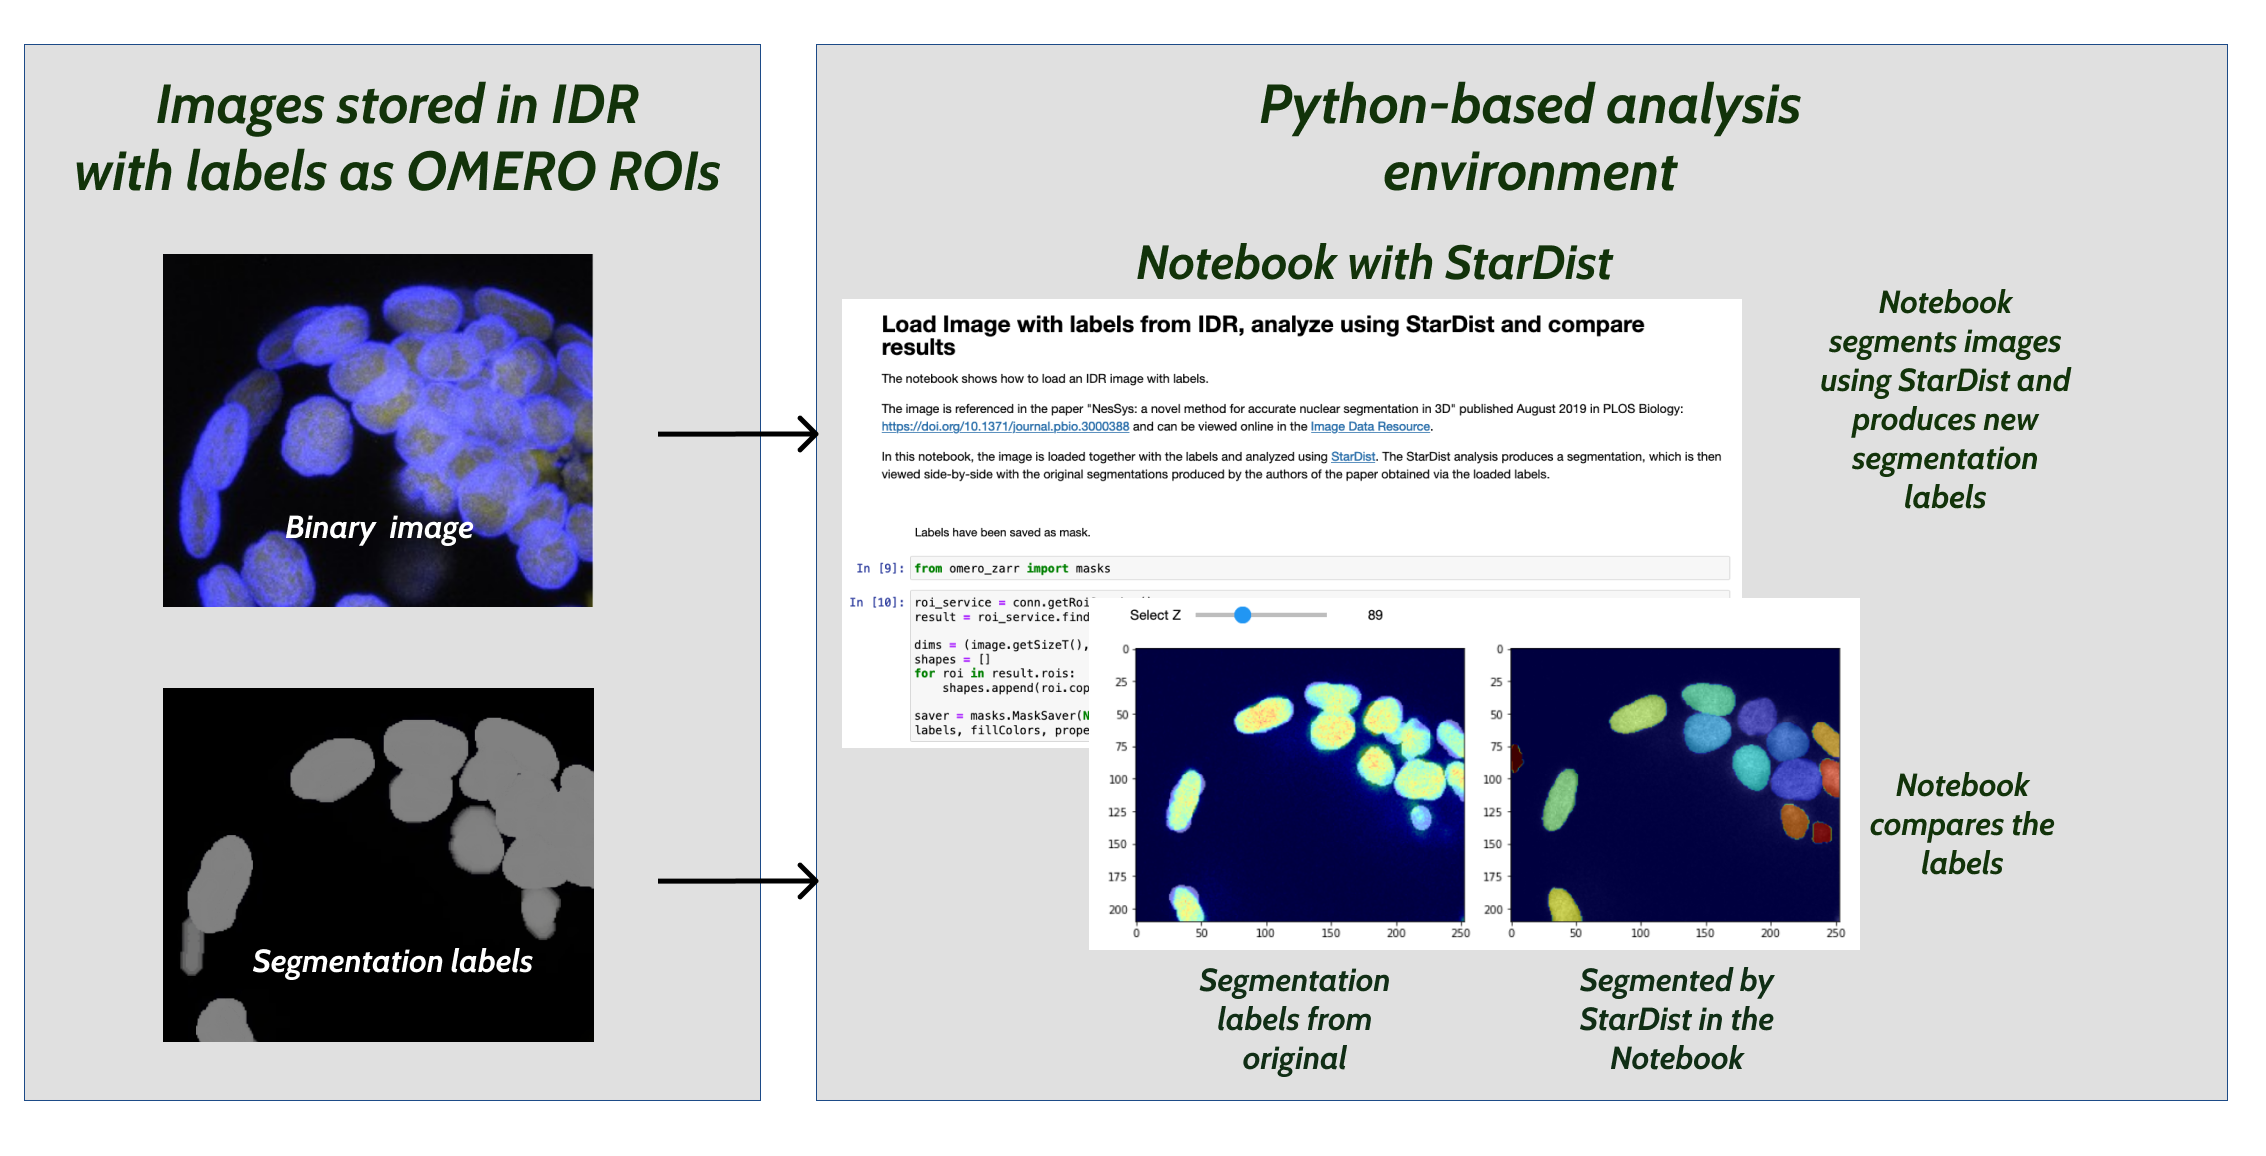

This notebook contains a few exercises, the solutions are available in a separate [notebook](Solutions_0_Python_API.ipynb).

If you are running the notebook in [Google Colab](https://colab.research.google.com/), run the cell below to install required dependencies. This could take a bit of time.

In [ ]:
%pip install omero-py omero-cli-zarr stardist==0.8.1

## First connect to IDR

This is the first step to any action when using the Python API.

In [48]:
from omero.gateway import BlitzGateway
HOST = 'ws://idr.openmicroscopy.org/omero-ws'
conn = BlitzGateway('public', 'public',
                    host=HOST, secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

True


## Load an image

We load information about the image but **not** the binary data. An image is a 5D-object (XYZCT).

In [49]:
image_id = 6001247

In [50]:
image = conn.getObject("Image", image_id)
print(image.getName())

B4_C3.tif


To get the dimension along an axis e.g. x-axis. Do:

In [56]:
print("Size X: %s, Size Y: %s" % (image.getSizeX(), image.getSizeY()))

Size X: 253, Size Y: 210


Exercise: Print the version along the T and C axis

## Load the binary data

To access the binary data, we need to load the `pixels` object from the image and retrieve the plane(s)

In [52]:
pixels = image.getPrimaryPixels()

When using the API, you can selectively load only the planes you need for your analysis. This is an advantage when using analytical tools requiring planar data, e.g. CellProfiler. The example below shows how to load one plane as a `YX` [NumPy](https://numpy.org/) array.
We load the plane ``z, t, c = 0, 0, 0 `` 

In [53]:
plane = pixels.getPlane(0, 0, 0)
# Check the size of the array using the numpy ``shape`` method.
print(plane.shape)

(210, 253)


To reshape the array, you can use ``numpy.reshape``. In this example, below we swap ``X`` and ``Y``.

In [55]:
import numpy
size_x = image.getSizeX()
size_y = image.getSizeY()
shape = (size_x, size_y)
p = numpy.reshape(plane, newshape=shape)
print(p.shape)

(253, 210)


To load multiple planes use ``pixels.getPlanes()``

In [61]:
zct_list = [(0, 0, 0), (1, 0, 0)]
planes = pixels.getPlanes(zct_list)
l = list(planes)
print(len(l))

2


Create a stack combining the 2 ``YX``-planes retrieved above using ``numpy.stack``

In [63]:
stack = numpy.stack(l)
print(stack.shape)

(2, 210, 253)


## Exercise: Load the 5D image as a `TCZYX` numpy array

Using the example below. 
* Create a method `load_numpy_array` taking the image as a parameter
* Iterate over the T, C, Z axis and create a list of coordinates
* Use the ``getPlanes`` method to load the 2D numpy array.
* Use the ``numpy.stack`` method to create an 5D numpy array
* Check the dimension order of the 5D numpy array, reshape using `numpy.reshape` to create an array in the order `TCZYX`.

## Load the 5D array

Using the method created in the exercise. We load the binary data as 5D numpy array. If you did not manage to go through the exercise, copy the method from the [Solutions](Solutions_0_Python_API.ipynb) notebook into a new cell in this notebook and execute it.

In [ ]:
data = load_numpy_array(image)

## Load StarDist trained model 

We use an existing trained model from StarDist. The tool was introduced during Day 1.
Please check StarDist documentation and examples to load your own model

In [47]:
from stardist.models import StarDist2D
model_versatile = StarDist2D.from_pretrained('2D_demo')

Found model '2D_demo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.486166, nms_thresh=0.5.


## Prediction based on a default StarDist model

Normalize the input image

``model_versatile.predict_instances`` will

* predict object probabilities and star-convex polygon distances (see model.predict if you want those)
* perform non-maximum suppression (with overlap threshold nms_thresh) for polygons above object probability threshold prob_thresh.
* render all remaining polygon instances in a label image
* return the label instances image and also the details (coordinates, etc.) of all remaining polygons

We will analyze the second channel i.e. ``c = 1``. We could have only loaded the second channel. This is left as an exercise for you. 
### Exercise: 
Adjust the ``load_numpy_array`` method above to only load the second channel.

In [ ]:
# Channel to analyze
c = 1
from csbdeep.utils import normalize
axis_norm = (0,1)
img = normalize(data[0, c, :, :, :], 1,99.8, axis=axis_norm)
results = []
results_details = []
for i in range(len(img)):
    new_labels, details = model_versatile.predict_instances(img[i])
    results_details.append(details)
    results.append(new_labels)

label_slices = numpy.array(results)

## Load the ROIs from IDR

Load the original labels in order to compare them with the StarDist ones Original labels have been saved as mask.

In [ ]:
roi_service = conn.getRoiService()
result = roi_service.findByImage(image_id, None)

shapes = []
for roi in result.rois:
    shapes.append(roi.copyShapes())

To compare the labels, we need to convert the masks into a NumPy array. 

In [23]:
from omero_zarr import masks
dims = (image.getSizeT(), image.getSizeC(), image.getSizeZ(), image.getSizeY(), image.getSizeX())
saver = masks.MaskSaver(None, image, numpy.int64)
labels, fillColors, properties = saver.masks_to_labels(shapes, mask_shape=dims)

## Compare labels

Display the original labels and the labels based on StarDist prediction side-by-side

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import *

def update(z=0):
    c = 1
    fig = plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(data[0, c, z, :, :], cmap='jet')
    try:
        plt.imshow(labels[0, c, z, :, :], cmap='gray', alpha=0.5)
    except Exception:
        print(z)
    plt.subplot(122)
    plt.imshow(data[0, c, z, :, :], cmap='gray')
    plt.imshow(label_slices[z, :, :], cmap='jet', alpha=0.5)
    plt.tight_layout()
    fig.canvas.flush_events()

interact(update, z= widgets.IntSlider(value=1, min=0, max=data.shape[2]-1, step=1, description="Select Z", continuous_update=False))


## Close the connection

In [ ]:
conn.close()

## Exercise: Load the data and the labels from S3 

The original image has been converted into Zarr and is available on S3.
Using approach presented during Day 3, retrieve the data and labels from S3 instead of IDR and compare the output with the StarDist labels. Find the [solution notebook](Solutions_0_Python_API.ipynb) to check the correctness.

### License (BSD 2-Clause)
Copyright (C) 2022 University of Dundee. All Rights Reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.